# Project

Sentiment Analysis and Topic modeling for the hotel industry in the most popular cities in the world.

### 1. Installing libraries

In [50]:
pip install vaderSentiment

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [51]:
pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [52]:
pip install torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [53]:
pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [54]:
pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


### 2. Import libraries

In [6]:
import numpy as np
import pandas as pd

In [7]:
# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.decomposition import LatentDirichletAllocation

In [10]:
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [12]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [13]:
#import imageio
from wordcloud import WordCloud, STOPWORDS

In [14]:
# Other imports
from collections import Counter
import requests
import re
import string
import tqdm as notebook_tqdm

In [15]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 3. Clean Data

In [16]:
full_path = './hotels_reviews.csv'

In [17]:
data = pd.read_csv(full_path)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254573 entries, 0 to 254572
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   country         254573 non-null  object
 1   city            254573 non-null  object
 2   hotel           254573 non-null  object
 3   date            254573 non-null  object
 4   review          254571 non-null  object
 5   review_details  227197 non-null  object
dtypes: object(6)
memory usage: 11.7+ MB


In [19]:
data.head()

,country,city,hotel,date,review,review_details
0,china,shanghai,park hotel shanghai,2009-11-02 00:00:00,Great Location Cheap hotel Werid smell,"This is really a weird hotel, sure some parts ..."
1,china,shanghai,park hotel shanghai,2009-10-22 00:00:00,Nice but half old!,Hard to tell about my feelings about this hote...
2,china,shanghai,park hotel shanghai,2009-07-30 00:00:00,Hotel with history- great location and good value,Even though it's no longer the tallest buildin...
3,china,shanghai,park hotel shanghai,2009-06-03 00:00:00,Stay clear of this one,"Well, it is noisy.The service at the front des..."
4,china,shanghai,park hotel shanghai,2008-07-23 00:00:00,Local Insights,Hmmm! A dated old hotel that needs to learn ab...


In [20]:
for column in data.columns:
    if data[column].dtype == 'object':
        print("--------------------------------")
        print(column,'\n')
        print(data[column].value_counts(),'\n')

--------------------------------
country 

country
usa      130281
uk        79349
can       18663
are       11834
china      9529
india      4917
Name: count, dtype: int64 

--------------------------------
city 

city
england          79349
new york city    55143
san francisco    30401
nevada           26506
illinois         18231
dubai            11834
montreal          9333
quebec            9330
beijing           5253
new delhi         4917
shanghai          4276
Name: count, dtype: int64 

--------------------------------
hotel 

hotel
las-vegas riviera hotel casino        602
le parker meridien                    580
embassy suites hotel new york city    580
red roof inn manhattan                565
hilton times square                   528
                                     ... 
terrace st denis                        1
montreal terrace st denis               1
grand palace hotel apartments           1
dubai concorde residence hotel          1
excelsior creek                 

In [21]:
# Rename columns
data['country'] = data['country'].replace('can', 'canada')
data['country'] = data['country'].replace('are', 'united arab emirates')

In [22]:
# Join two columns that have reviews information
data['hotel_review'] = data.apply(lambda row: f"{row['review']} {row['review_details']}", axis=1)

In [23]:
# Delete the columns that were joined
data.drop("review", axis=1, inplace=True)
data.drop("review_details", axis=1, inplace=True)

In [24]:
data.head()

,country,city,hotel,date,hotel_review
0,china,shanghai,park hotel shanghai,2009-11-02 00:00:00,Great Location Cheap hotel Werid smell This is...
1,china,shanghai,park hotel shanghai,2009-10-22 00:00:00,Nice but half old! Hard to tell about my feeli...
2,china,shanghai,park hotel shanghai,2009-07-30 00:00:00,Hotel with history- great location and good va...
3,china,shanghai,park hotel shanghai,2009-06-03 00:00:00,"Stay clear of this one Well, it is noisy.The s..."
4,china,shanghai,park hotel shanghai,2008-07-23 00:00:00,Local Insights Hmmm! A dated old hotel that ne...


### 4. Sample Data

Make a sample of the dataset with the first 2000 reviews of each city.

In [25]:
result = data.groupby('city').head(2000)

In [26]:
result.to_csv('sample_data.csv', index=False)

In [27]:
sample_path = './sample_data.csv'

In [28]:
sample = pd.read_csv(sample_path)

### 5. EDA

Explore the data to understand it, and guide model selection. 

In [29]:
top_hotel = data.hotel.mode()[0]
top_country = data.country.mode()[0]
top_city = data.city.mode()[0]

In [30]:
print(top_hotel,',', top_country, ',', top_city)

las-vegas riviera hotel casino , usa , england


In [31]:
top_hotel_sample = sample.hotel.mode()[0]
top_country_sample = sample.country.mode()[0]
top_city_sample = sample.city.mode()[0]

In [32]:
print(top_hotel_sample,',', top_country_sample, ',', top_city_sample)

jumeirah beach hotel , usa , beijing


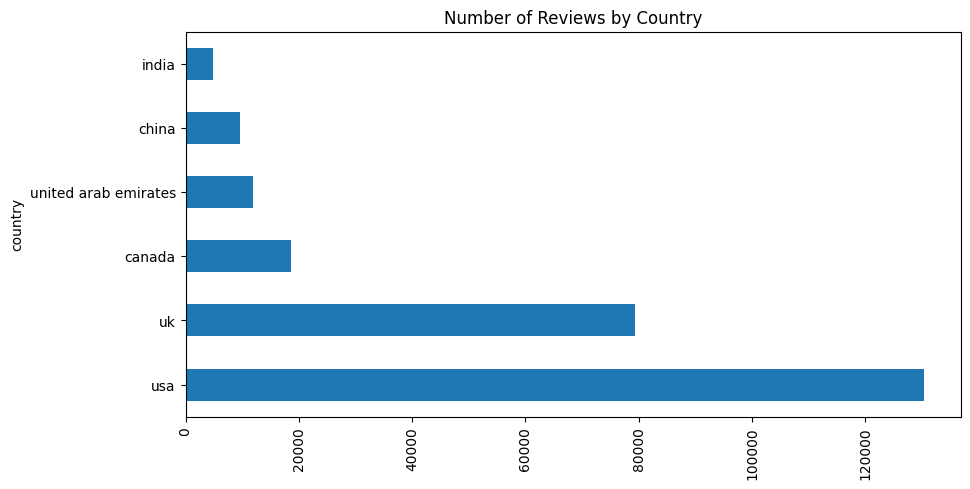

In [33]:
plt.figure(figsize = (10,5))

plt.title('Number of Reviews by Country')
plt.ylabel('Countries')
plt.xlabel('Num of Reviews')

plt.tick_params(axis='x', rotation = 90)

data['country'].value_counts().plot(kind='barh') 

# prints the plot
plt.show()

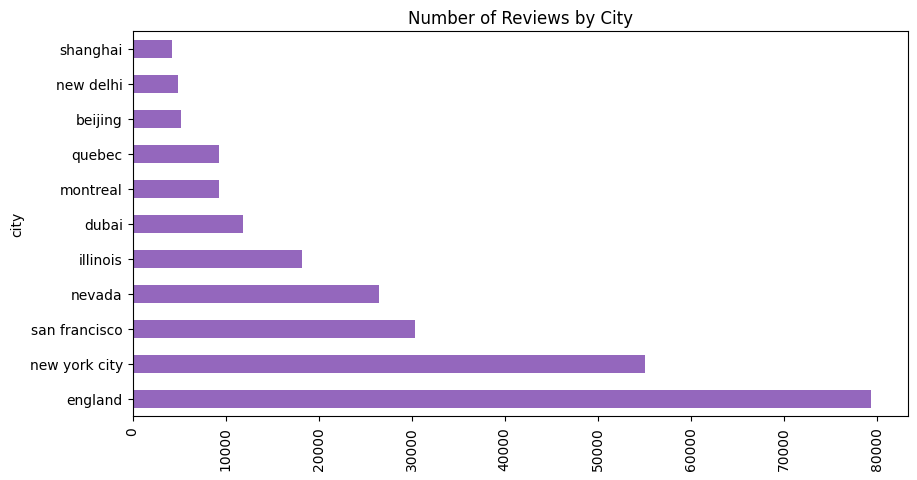

In [34]:
plt.figure(figsize = (10,5))
plt.title('Number of Reviews by City')
plt.ylabel('Cities')
plt.xlabel('Number of Reviews')
plt.tick_params(axis='x', rotation = 90)

data['city'].value_counts().plot(kind='barh',color=['C4']) 

plt.show()

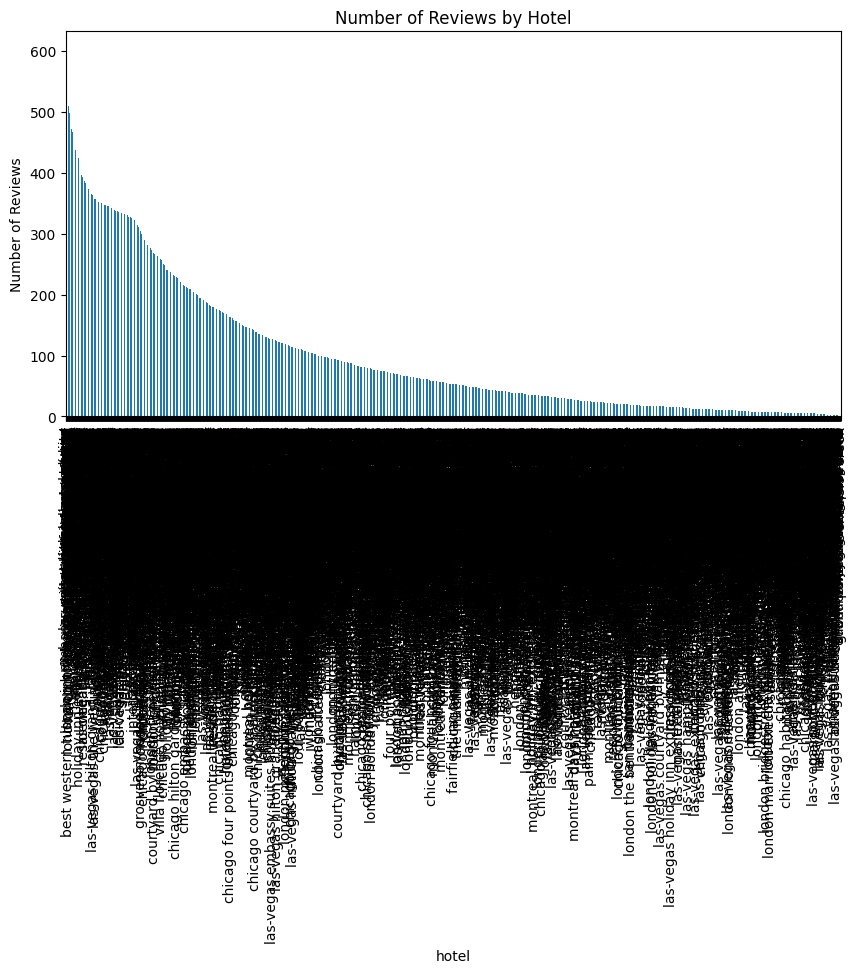

In [35]:
plt.figure(figsize = (10,5))
plt.title('Number of Reviews by Hotel')
plt.ylabel('Number of Reviews')
plt.xlabel('Hotel')

data['hotel'].value_counts().plot(kind='bar') 

plt.show()

### 6. VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) will analyze the sentiment of words in a text. In this case it will analyze the hotel reviews of clients.

In [36]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [37]:
analyser

In [38]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [39]:
sample['hotel_review'].apply(lambda x: sentiment_analyzer_scores(x))

0        0.9542
1        0.7341
2        0.9312
3        0.9289
4       -0.8268
          ...  
21995    0.9305
21996    0.1989
21997    0.9844
21998    0.9574
21999    0.1280
Name: hotel_review, Length: 22000, dtype: float64

In [40]:
sample['sentiment'] = sample['hotel_review'].apply(lambda x: sentiment_analyzer_scores(x))

In [41]:
sample.head()

,country,city,hotel,date,hotel_review,sentiment
0,china,shanghai,park hotel shanghai,2009-11-02 00:00:00,Great Location Cheap hotel Werid smell This is...,0.9542
1,china,shanghai,park hotel shanghai,2009-10-22 00:00:00,Nice but half old! Hard to tell about my feeli...,0.7341
2,china,shanghai,park hotel shanghai,2009-07-30 00:00:00,Hotel with history- great location and good va...,0.9312
3,china,shanghai,park hotel shanghai,2009-06-03 00:00:00,"Stay clear of this one Well, it is noisy.The s...",0.9289
4,china,shanghai,park hotel shanghai,2008-07-23 00:00:00,Local Insights Hmmm! A dated old hotel that ne...,-0.8268


In [42]:
def classify_sentiment(score):
    if score > 0.8:
        return "positive"
    elif score > 0.0:
        return "neutral"
    else:
        return "negative"

In [43]:
sample['sentiment_classification'] = sample['sentiment'].apply(classify_sentiment)

In [44]:
sample.head()

,country,city,hotel,date,hotel_review,sentiment,sentiment_classification
0,china,shanghai,park hotel shanghai,2009-11-02 00:00:00,Great Location Cheap hotel Werid smell This is...,0.9542,positive
1,china,shanghai,park hotel shanghai,2009-10-22 00:00:00,Nice but half old! Hard to tell about my feeli...,0.7341,neutral
2,china,shanghai,park hotel shanghai,2009-07-30 00:00:00,Hotel with history- great location and good va...,0.9312,positive
3,china,shanghai,park hotel shanghai,2009-06-03 00:00:00,"Stay clear of this one Well, it is noisy.The s...",0.9289,positive
4,china,shanghai,park hotel shanghai,2008-07-23 00:00:00,Local Insights Hmmm! A dated old hotel that ne...,-0.8268,negative


### 7. RoBERTa

With RoBERTa model, each hotel review will be process to add emotion scores as new columns in the DataFrame.

In [45]:
def add_emotion_columns(df, review_column='hotel_review', model_name="joeddav/distilbert-base-uncased-go-emotions-student"):
    
    # Load pre-trained model and tokenizer
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    
    # Get the emotion labels from the model
    emotions = [model.config.id2label[i] for i in range(model.config.num_labels)]
    
    # Create empty columns for emotions
    result_df = df.copy()
    for emotion in emotions:
        result_df[f'emotion_{emotion}'] = 0.0
    
    # Process each review
    print(f"Processing {len(df)} reviews...")
    for idx, row in df.iterrows():
        if idx % 100 == 0 and idx > 0:
            print(f"Processed {idx} reviews...")
            
        review = row[review_column]
        
        # Skip empty reviews
        if pd.isna(review) or review == "":
            continue
            
        # Tokenize the review
        encoded_review = tokenizer(review, return_tensors='pt', truncation=True, max_length=512)
        
        # Get model prediction
        with torch.no_grad():
            output = model(**encoded_review)
        
        # Convert logits to probabilities
        scores = softmax(output.logits.numpy(), axis=1)[0]
        
        # Add emotion scores to the DataFrame
        for i, emotion in enumerate(emotions):
            result_df.at[idx, f'emotion_{emotion}'] = float(scores[i])
    
    print("Processing complete!")
    return result_df

In [48]:
df = pd.DataFrame(sample)

In [49]:
# Add emotion columns
hotel_df_with_emotions = add_emotion_columns(df, review_column='hotel_review', model_name="joeddav/distilbert-base-uncased-go-emotions-student")

Loading model and tokenizer...
Processing 22000 reviews...
Processed 100 reviews...
Processed 200 reviews...
Processed 300 reviews...
Processed 400 reviews...
Processed 500 reviews...
Processed 600 reviews...
Processed 700 reviews...
Processed 800 reviews...
Processed 900 reviews...
Processed 1000 reviews...
Processed 1100 reviews...
Processed 1200 reviews...
Processed 1300 reviews...
Processed 1400 reviews...
Processed 1500 reviews...
Processed 1600 reviews...
Processed 1700 reviews...
Processed 1800 reviews...
Processed 1900 reviews...
Processed 2000 reviews...
Processed 2100 reviews...
Processed 2200 reviews...
Processed 2300 reviews...
Processed 2400 reviews...
Processed 2500 reviews...
Processed 2600 reviews...
Processed 2700 reviews...
Processed 2800 reviews...
Processed 2900 reviews...
Processed 3000 reviews...
Processed 3100 reviews...
Processed 3200 reviews...
Processed 3300 reviews...
Processed 3400 reviews...
Processed 3500 reviews...
Processed 3600 reviews...
Processed 3700

In [56]:
df = hotel_df_with_emotions

In [57]:
def add_dominant_emotion(df):
    # Find all emotion columns
    emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
    
    # Skip if no emotion columns found
    if not emotion_cols:
        print("No emotion columns found in the DataFrame")
        return df
    
    # Create a new DataFrame for storing results
    result_df = df.copy()
    
    # Add dominant emotion column
    result_df['dominant_emotion'] = result_df[emotion_cols].idxmax(axis=1)
    
    # Clean up the emotion name (remove 'emotion_' prefix)
    result_df['dominant_emotion'] = result_df['dominant_emotion'].str.replace('emotion_', '')
    
    # Add dominant emotion score
    result_df['dominant_emotion_score'] = result_df[emotion_cols].max(axis=1)
    
    return result_df

In [58]:
# Find all emotion columns
emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
print(f"Found {len(emotion_cols)} emotion columns: {emotion_cols}")

Found 28 emotion columns: ['emotion_admiration', 'emotion_amusement', 'emotion_anger', 'emotion_annoyance', 'emotion_approval', 'emotion_caring', 'emotion_confusion', 'emotion_curiosity', 'emotion_desire', 'emotion_disappointment', 'emotion_disapproval', 'emotion_disgust', 'emotion_embarrassment', 'emotion_excitement', 'emotion_fear', 'emotion_gratitude', 'emotion_grief', 'emotion_joy', 'emotion_love', 'emotion_nervousness', 'emotion_optimism', 'emotion_pride', 'emotion_realization', 'emotion_relief', 'emotion_remorse', 'emotion_sadness', 'emotion_surprise', 'emotion_neutral']


In [59]:
# Add the dominant emotion
df = add_dominant_emotion(df)

In [60]:
# Show the distribution of dominant emotions
emotion_counts = df['dominant_emotion'].value_counts()
print("\nDistribution of dominant emotions:")
print(emotion_counts)


Distribution of dominant emotions:
dominant_emotion
caring            9644
excitement        2169
disappointment    1961
confusion         1471
desire            1199
approval           994
remorse            715
surprise           702
annoyance          685
admiration         475
gratitude          354
relief             272
joy                259
curiosity          219
disapproval        196
realization        159
amusement          115
nervousness         86
love                58
sadness             49
pride               48
neutral             41
optimism            41
disgust             41
anger               23
fear                13
embarrassment       11
Name: count, dtype: int64


In [61]:
# Calculate average sentiment by dominant emotion
if 'sentiment' in df.columns:
    emotion_sentiment = df.groupby('dominant_emotion')['sentiment'].mean().sort_values(ascending=False)
    print("\nAverage sentiment by dominant emotion:")
    print(emotion_sentiment)


Average sentiment by dominant emotion:
dominant_emotion
caring            0.916793
gratitude         0.906760
remorse           0.839439
surprise          0.829658
love              0.829593
joy               0.824757
desire            0.821239
admiration        0.807077
excitement        0.785669
optimism          0.670546
curiosity         0.640537
relief            0.563935
nervousness       0.548953
approval          0.539885
confusion         0.332382
amusement         0.319846
annoyance         0.253150
neutral           0.190883
sadness           0.180269
pride             0.175763
disapproval       0.116047
realization       0.103835
anger            -0.066613
disappointment   -0.099797
embarrassment    -0.101964
fear             -0.212369
disgust          -0.630422
Name: sentiment, dtype: float64


In [62]:
def process_existing_hotel_dataset(df):    
    # Find all emotion columns
    emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
    print(f"Found {len(emotion_cols)} emotion columns: {emotion_cols}")
    
    # Add the dominant emotion
    df = add_dominant_emotion(df)
    
    # Show the distribution of dominant emotions
    emotion_counts = df['dominant_emotion'].value_counts()
    print("\nDistribution of dominant emotions:")
    print(emotion_counts)
    
    # Calculate average sentiment by dominant emotion
    if 'sentiment' in df.columns:
        emotion_sentiment = df.groupby('dominant_emotion')['sentiment'].mean().sort_values(ascending=False)
        print("\nAverage sentiment by dominant emotion:")
        print(emotion_sentiment)
    
    return df

In [63]:
# Use
processed_df = process_existing_hotel_dataset(df)

Found 28 emotion columns: ['emotion_admiration', 'emotion_amusement', 'emotion_anger', 'emotion_annoyance', 'emotion_approval', 'emotion_caring', 'emotion_confusion', 'emotion_curiosity', 'emotion_desire', 'emotion_disappointment', 'emotion_disapproval', 'emotion_disgust', 'emotion_embarrassment', 'emotion_excitement', 'emotion_fear', 'emotion_gratitude', 'emotion_grief', 'emotion_joy', 'emotion_love', 'emotion_nervousness', 'emotion_optimism', 'emotion_pride', 'emotion_realization', 'emotion_relief', 'emotion_remorse', 'emotion_sadness', 'emotion_surprise', 'emotion_neutral']

Distribution of dominant emotions:
dominant_emotion
caring            9644
excitement        2169
disappointment    1961
confusion         1471
desire            1199
approval           994
remorse            715
surprise           702
annoyance          685
admiration         475
gratitude          354
relief             272
joy                259
curiosity          219
disapproval        196
realization       

In [65]:
# Already an emotion columns:
emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
    
if emotion_cols:
    print(f"Found {len(emotion_cols)} emotion columns")
    # Add dominant emotion if needed
    if 'dominant_emotion' not in df.columns:
        print("Adding dominant emotion column...")
        df['dominant_emotion'] = df[emotion_cols].idxmax(axis=1)
        df['dominant_emotion'] = df['dominant_emotion'].str.replace('emotion_', '')
        df['dominant_emotion_score'] = df[emotion_cols].max(axis=1)
else:
    print("No emotion columns found. You would need to run the emotion extraction model here.")
    # This would be where you'd call add_emotion_columns() or add_emotion_columns_batch()

Found 28 emotion columns


In [66]:
df.head()

,country,city,hotel,date,hotel_review,sentiment,sentiment_classification,emotion_admiration,emotion_amusement,emotion_anger,...,emotion_optimism,emotion_pride,emotion_realization,emotion_relief,emotion_remorse,emotion_sadness,emotion_surprise,emotion_neutral,dominant_emotion,dominant_emotion_score
0,china,shanghai,park hotel shanghai,2009-11-02 00:00:00,Great Location Cheap hotel Werid smell This is...,0.9542,positive,0.027856,0.009696,0.014524,...,0.012567,0.017650,0.038016,0.018606,0.064043,0.020209,0.030800,0.017647,approval,0.094863
1,china,shanghai,park hotel shanghai,2009-10-22 00:00:00,Nice but half old! Hard to tell about my feeli...,0.7341,neutral,0.024485,0.011040,0.010333,...,0.008950,0.013330,0.025285,0.010557,0.047987,0.019890,0.026675,0.018214,confusion,0.156287
2,china,shanghai,park hotel shanghai,2009-07-30 00:00:00,Hotel with history- great location and good va...,0.9312,positive,0.055344,0.017033,0.008137,...,0.030027,0.032911,0.052427,0.041671,0.093300,0.006874,0.050032,0.028029,caring,0.114446
3,china,shanghai,park hotel shanghai,2009-06-03 00:00:00,"Stay clear of this one Well, it is noisy.The s...",0.9289,positive,0.008891,0.007275,0.041976,...,0.006279,0.010806,0.025826,0.006490,0.035301,0.018483,0.021101,0.012475,annoyance,0.227336
4,china,shanghai,park hotel shanghai,2008-07-23 00:00:00,Local Insights Hmmm! A dated old hotel that ne...,-0.8268,negative,0.013321,0.014795,0.019228,...,0.009291,0.011375,0.030011,0.007618,0.055489,0.030029,0.055411,0.015120,confusion,0.108572


### 8. LDA

Latent Dirichlet Allocation (LDA) will be used to discover topics in the hotel reviews text by modeling words as mixtures of topics.

In [67]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreaespino/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [68]:
# Download NLTK data (run once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaespino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreaespino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
df['hotel_review'].str.replace(',', '')

0        Great Location Cheap hotel Werid smell This is...
1        Nice but half old! Hard to tell about my feeli...
2        Hotel with history- great location and good va...
3        Stay clear of this one Well it is noisy.The se...
4        Local Insights Hmmm! A dated old hotel that ne...
                               ...                        
21995    Got the big things right not the little Had bo...
21996    Small not a good deal Good location that's abo...
21997    Better than expected We stayed in Menton Hotel...
21998    much better than expected... I had read all th...
21999    Don't stay there My family and I had a &quot;t...
Name: hotel_review, Length: 22000, dtype: object

In [70]:
df['hotel_review'] = df['hotel_review'].str.replace(',', '')

In [71]:
nltk.word_tokenize('the idea is that we tokenise everything')

['the', 'idea', 'is', 'that', 'we', 'tokenise', 'everything']

In [72]:
df['hotel_review'].apply(lambda x:  nltk.word_tokenize(x))

0        [Great, Location, Cheap, hotel, Werid, smell, ...
1        [Nice, but, half, old, !, Hard, to, tell, abou...
2        [Hotel, with, history-, great, location, and, ...
3        [Stay, clear, of, this, one, Well, it, is, noi...
4        [Local, Insights, Hmmm, !, A, dated, old, hote...
                               ...                        
21995    [Got, the, big, things, right, not, the, littl...
21996    [Small, not, a, good, deal, Good, location, th...
21997    [Better, than, expected, We, stayed, in, Mento...
21998    [much, better, than, expected, ..., I, had, re...
21999    [Do, n't, stay, there, My, family, and, I, had...
Name: hotel_review, Length: 22000, dtype: object

In [73]:
df['hotel_review_tok'] = df['hotel_review'].apply(lambda x:  nltk.word_tokenize(x))

In [74]:
df['hotel_review_tok']

0        [Great, Location, Cheap, hotel, Werid, smell, ...
1        [Nice, but, half, old, !, Hard, to, tell, abou...
2        [Hotel, with, history-, great, location, and, ...
3        [Stay, clear, of, this, one, Well, it, is, noi...
4        [Local, Insights, Hmmm, !, A, dated, old, hote...
                               ...                        
21995    [Got, the, big, things, right, not, the, littl...
21996    [Small, not, a, good, deal, Good, location, th...
21997    [Better, than, expected, We, stayed, in, Mento...
21998    [much, better, than, expected, ..., I, had, re...
21999    [Do, n't, stay, there, My, family, and, I, had...
Name: hotel_review_tok, Length: 22000, dtype: object

In [75]:
#Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Add hotel-specific stopwords
    hotel_stopwords = {'hotel', 'room', 'rooms', 'stay', 'stayed'}
    stop_words = stop_words.union(hotel_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [76]:
reviews = df['hotel_review'].tolist()

In [77]:
# Apply preprocessing
processed_reviews = [preprocess_text(review) for review in reviews]

In [78]:
# Create a document-term matrix (Bag of Words)
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
dtm = vectorizer.fit_transform(processed_reviews)

In [79]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

In [80]:
# Apply LDA
# Choose the number of topics
n_topics = 3

In [81]:
# Create and fit the LDA model
lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='online',
    max_iter=20
)

In [82]:
lda_output = lda_model.fit_transform(dtm)

In [83]:
# Print the topics and their top words
def print_topics(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[topic_idx] = top_words
        print(f"Topic #{topic_idx+1}:")
        print(" ".join(top_words))
        print()
    return topics

In [84]:
# Show topics
topics_dict = print_topics(lda_model, feature_names)

Topic #1:
service staff great pool restaurant food time one good would

Topic #2:
great location good nice clean staff breakfast comfortable restaurant walk

Topic #3:
night would one get time day didnt bed could like



In [85]:
# Visualize the topics
# Create a DataFrame for the topic distribution in each document
topic_distributions = lda_output
topic_names = [f"Topic {i+1}" for i in range(n_topics)]
doc_names = [f"Review {i+1}" for i in range(len(reviews))]

df_topic_distribution = pd.DataFrame(topic_distributions, columns=topic_names, index=doc_names)

In [86]:
# Display the topic distribution for each document
print("\nTopic Distribution per Document:")
print(df_topic_distribution)


Topic Distribution per Document:
               Topic 1   Topic 2   Topic 3
Review 1      0.009878  0.884934  0.105188
Review 2      0.007620  0.347348  0.645032
Review 3      0.008739  0.721618  0.269643
Review 4      0.008385  0.222140  0.769474
Review 5      0.007325  0.276786  0.715889
...                ...       ...       ...
Review 21996  0.014924  0.720403  0.264673
Review 21997  0.031866  0.456328  0.511806
Review 21998  0.084833  0.476348  0.438819
Review 21999  0.016139  0.722449  0.261413
Review 22000  0.009212  0.009148  0.981640

[22000 rows x 3 columns]


In [87]:
# Add dominant topic to the DataFrame
# Find the dominant topic for each review
dominant_topic_idx = np.argmax(lda_output, axis=1)

In [88]:
# Add the dominant topic index (0-based)
df['dominant_topic_idx'] = dominant_topic_idx

In [89]:
# Add 1-based topic numbers (Topic 1, Topic 2, etc.)
df['dominant_topic'] = dominant_topic_idx + 1

In [90]:
# Create a function to get the top words for each topic
def get_topic_keywords(topic_idx, topics_dict, num_words=5):
    return ', '.join(topics_dict[topic_idx][:num_words])

In [91]:
# Add the top keywords for each dominant topic
df['dominant_topic_keywords'] = df['dominant_topic_idx'].apply(
    lambda x: get_topic_keywords(x, topics_dict)
)

In [92]:
# Display the updated DataFrame
print("\nDataFrame with Dominant Topic Information:")
print(df[['hotel_review', 'dominant_topic', 'dominant_topic_keywords']])


DataFrame with Dominant Topic Information:
                                            hotel_review  dominant_topic  \
0      Great Location Cheap hotel Werid smell This is...               2   
1      Nice but half old! Hard to tell about my feeli...               3   
2      Hotel with history- great location and good va...               2   
3      Stay clear of this one Well it is noisy.The se...               3   
4      Local Insights Hmmm! A dated old hotel that ne...               3   
...                                                  ...             ...   
21995  Got the big things right not the little Had bo...               2   
21996  Small not a good deal Good location that's abo...               3   
21997  Better than expected We stayed in Menton Hotel...               2   
21998  much better than expected... I had read all th...               2   
21999  Don't stay there My family and I had a &quot;t...               3   

                  dominant_topic_keywords  

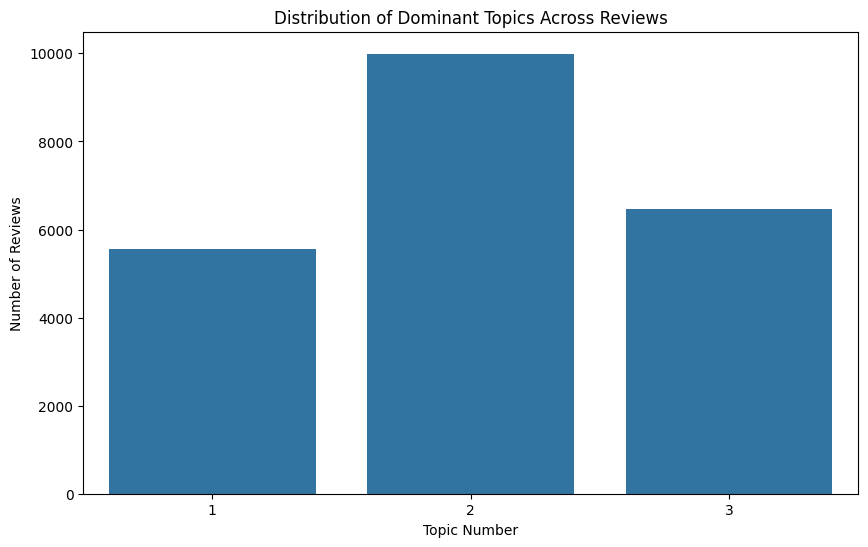

In [93]:
# Visualize the distribution of dominant topics
plt.figure(figsize=(10, 6))
sns.countplot(x='dominant_topic', data=df)
plt.title('Distribution of Dominant Topics Across Reviews')
plt.xlabel('Topic Number')
plt.ylabel('Number of Reviews')
plt.show()

In [94]:
# Manual topic labeling
topic_labels = {
    0: "Room Quality & Cleanliness",
    1: "Staff & Service", 
    2: "Location & Amenities"
}

In [95]:
# Add labels to DataFrame
df['topic_label'] = df['dominant_topic_idx'].map(topic_labels)

In [97]:
def get_topic_keyword(topic_idx, topics_dict, num_words=1):
    return ', '.join(topics_dict[topic_idx][:num_words])

In [98]:
df['dominant_topic_keyword'] = df['dominant_topic_idx'].apply(
    lambda x: get_topic_keyword(x, topics_dict)
)

In [99]:
df.head()

,country,city,hotel,date,hotel_review,sentiment,sentiment_classification,emotion_admiration,emotion_amusement,emotion_anger,...,emotion_surprise,emotion_neutral,dominant_emotion,dominant_emotion_score,hotel_review_tok,dominant_topic_idx,dominant_topic,dominant_topic_keywords,topic_label,dominant_topic_keyword
0,china,shanghai,park hotel shanghai,2009-11-02 00:00:00,Great Location Cheap hotel Werid smell This is...,0.9542,positive,0.027856,0.009696,0.014524,...,0.030800,0.017647,approval,0.094863,"[Great, Location, Cheap, hotel, Werid, smell, ...",1,2,"great, location, good, nice, clean",Staff & Service,great
1,china,shanghai,park hotel shanghai,2009-10-22 00:00:00,Nice but half old! Hard to tell about my feeli...,0.7341,neutral,0.024485,0.011040,0.010333,...,0.026675,0.018214,confusion,0.156287,"[Nice, but, half, old, !, Hard, to, tell, abou...",2,3,"night, would, one, get, time",Location & Amenities,night
2,china,shanghai,park hotel shanghai,2009-07-30 00:00:00,Hotel with history- great location and good va...,0.9312,positive,0.055344,0.017033,0.008137,...,0.050032,0.028029,caring,0.114446,"[Hotel, with, history-, great, location, and, ...",1,2,"great, location, good, nice, clean",Staff & Service,great
3,china,shanghai,park hotel shanghai,2009-06-03 00:00:00,Stay clear of this one Well it is noisy.The se...,0.9289,positive,0.008891,0.007275,0.041976,...,0.021101,0.012475,annoyance,0.227336,"[Stay, clear, of, this, one, Well, it, is, noi...",2,3,"night, would, one, get, time",Location & Amenities,night
4,china,shanghai,park hotel shanghai,2008-07-23 00:00:00,Local Insights Hmmm! A dated old hotel that ne...,-0.8268,negative,0.013321,0.014795,0.019228,...,0.055411,0.015120,confusion,0.108572,"[Local, Insights, Hmmm, !, A, dated, old, hote...",2,3,"night, would, one, get, time",Location & Amenities,night


In [100]:
output_csv = 'result.csv'

In [101]:
print(f"Exporting to {output_csv}...")
df.to_csv(output_csv, index=False)
print(f"Successfully exported {len(df)} rows to {output_csv}")

Exporting to result.csv...
Successfully exported 22000 rows to result.csv
